# Ignition Risk Predictor
## VIGIL Risk Planning - ML Model 3 of 4

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col, lit, when, current_date
from snowflake.ml.modeling.ensemble import GradientBoostingClassifier
from snowflake.ml.modeling.preprocessing import OrdinalEncoder, StandardScaler
from snowflake.ml.modeling.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import os
print('Libraries imported')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported


In [2]:
conn_name = os.getenv('SNOWFLAKE_CONNECTION_NAME', 'my_snowflake')
session = Session.builder.configs({'connection_name': conn_name}).create()
session.use_database('RISK_PLANNING_DB')
session.use_schema('ML')
session.use_warehouse('COMPUTE_WH')
print(f'Connected to {session.get_current_database()}')

Connected to "RISK_PLANNING_DB"


In [3]:
ignition_df = session.sql("""
    SELECT a.ASSET_ID, a.ASSET_TYPE, a.MATERIAL, a.ASSET_AGE_YEARS, a.CONDITION_SCORE, a.MOISTURE_EXPOSURE, a.WIND_EXPOSURE,
        COALESCE(v.AVG_CLEARANCE_DEFICIT, 0) as AVG_CLEARANCE_DEFICIT,
        COALESCE(v.MAX_GROWTH_RATE, 0) as MAX_GROWTH_RATE,
        COALESCE(v.ENCROACHMENT_COUNT, 0) as ENCROACHMENT_COUNT,
        CASE WHEN a.CONDITION_SCORE < 0.4 AND COALESCE(v.AVG_CLEARANCE_DEFICIT, 0) > 2 THEN 1
             WHEN COALESCE(v.MAX_GROWTH_RATE, 0) > 4 AND a.ASSET_AGE_YEARS > 20 THEN 1
             WHEN a.WIND_EXPOSURE = 'HIGH' AND a.CONDITION_SCORE < 0.5 THEN 1
             ELSE 0 END as HIGH_IGNITION_RISK
    FROM ATOMIC.ASSET a
    LEFT JOIN (SELECT ASSET_ID, AVG(CLEARANCE_DEFICIT_FT) as AVG_CLEARANCE_DEFICIT, MAX(GROWTH_RATE_FT_YEAR) as MAX_GROWTH_RATE, COUNT(*) as ENCROACHMENT_COUNT FROM ATOMIC.VEGETATION_ENCROACHMENT GROUP BY ASSET_ID) v ON a.ASSET_ID = v.ASSET_ID
    WHERE a.CONDITION_SCORE IS NOT NULL
""")
total_records = ignition_df.count()
print(f'Total Assets: {total_records:,}')
ignition_df.group_by('HIGH_IGNITION_RISK').count().show()

Total Assets: 5,000


----------------------------------
|"HIGH_IGNITION_RISK"  |"COUNT"  |
----------------------------------
|0                     |4123     |
|1                     |877      |
----------------------------------



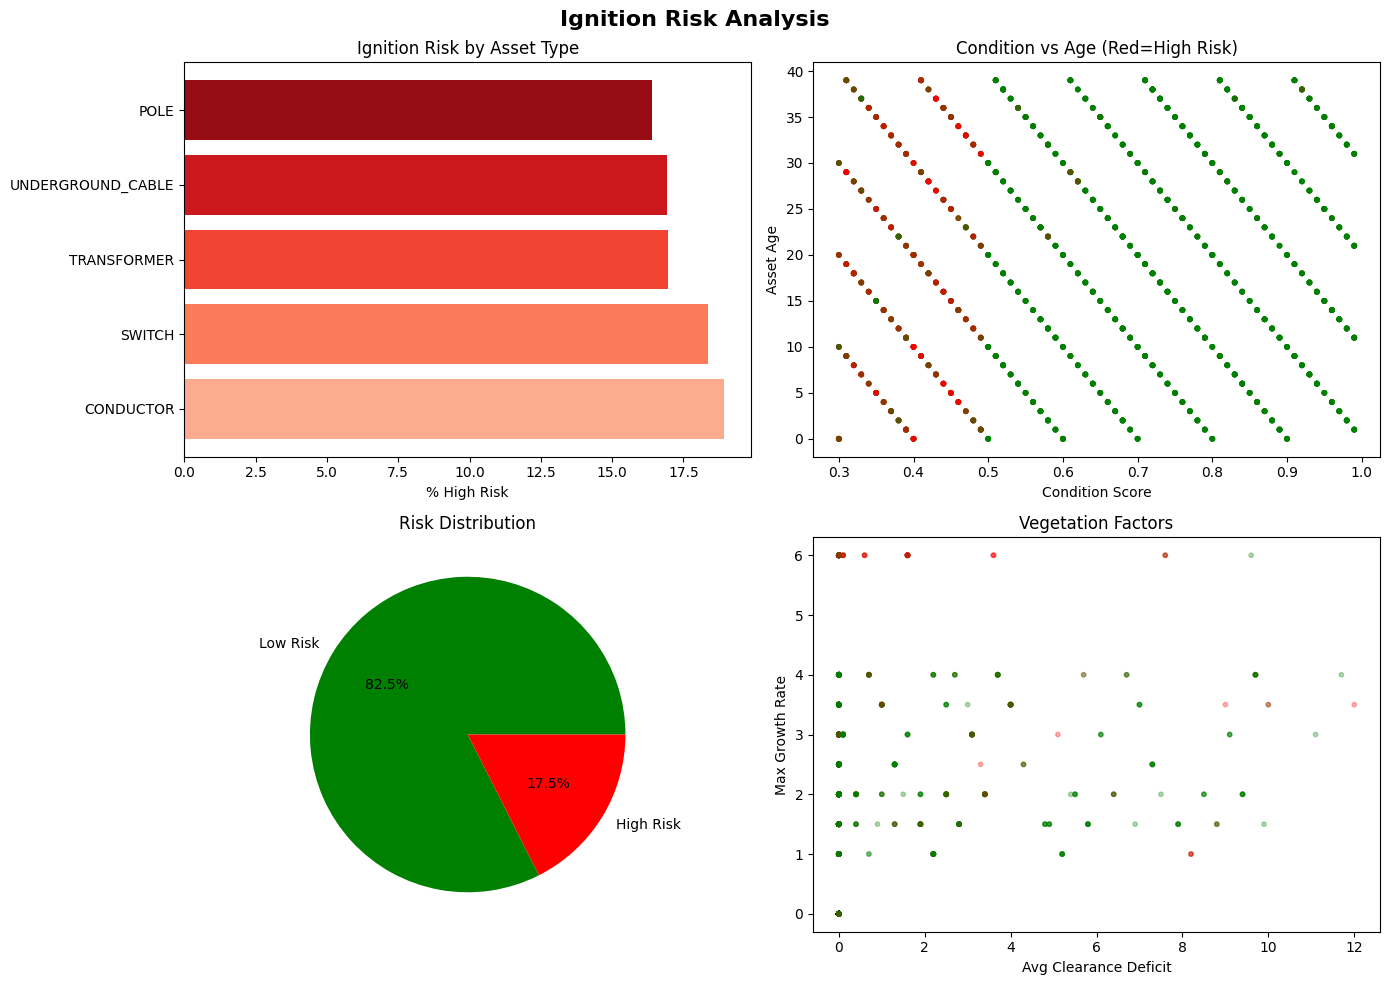

High Risk: 17.5%


In [4]:
ign_pd = ignition_df.to_pandas()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Ignition Risk Analysis', fontsize=16, fontweight='bold')
risk_by_type = ign_pd.groupby('ASSET_TYPE')['HIGH_IGNITION_RISK'].mean().sort_values(ascending=False)
axes[0,0].barh(risk_by_type.index, risk_by_type.values * 100, color=plt.cm.Reds(np.linspace(0.3, 0.9, len(risk_by_type))))
axes[0,0].set_xlabel('% High Risk')
axes[0,0].set_title('Ignition Risk by Asset Type')
risk_colors = ['green' if r == 0 else 'red' for r in ign_pd['HIGH_IGNITION_RISK']]
axes[0,1].scatter(ign_pd['CONDITION_SCORE'], ign_pd['ASSET_AGE_YEARS'], c=risk_colors, alpha=0.3, s=10)
axes[0,1].set_xlabel('Condition Score')
axes[0,1].set_ylabel('Asset Age')
axes[0,1].set_title('Condition vs Age (Red=High Risk)')
risk_counts = ign_pd['HIGH_IGNITION_RISK'].value_counts()
axes[1,0].pie(risk_counts.values, labels=['Low Risk', 'High Risk'], colors=['green', 'red'], autopct='%1.1f%%')
axes[1,0].set_title('Risk Distribution')
axes[1,1].scatter(ign_pd['AVG_CLEARANCE_DEFICIT'], ign_pd['MAX_GROWTH_RATE'], c=risk_colors, alpha=0.3, s=10)
axes[1,1].set_xlabel('Avg Clearance Deficit')
axes[1,1].set_ylabel('Max Growth Rate')
axes[1,1].set_title('Vegetation Factors')
plt.tight_layout()
plt.show()
print(f'High Risk: {ign_pd["HIGH_IGNITION_RISK"].mean()*100:.1f}%')

In [5]:
CATEGORICAL_FEATURES = ['ASSET_TYPE', 'MATERIAL', 'MOISTURE_EXPOSURE', 'WIND_EXPOSURE']
NUMERIC_FEATURES = ['ASSET_AGE_YEARS', 'CONDITION_SCORE', 'AVG_CLEARANCE_DEFICIT', 'MAX_GROWTH_RATE', 'ENCROACHMENT_COUNT']
TARGET = 'HIGH_IGNITION_RISK'
filtered_df = ignition_df.filter(col('ASSET_TYPE').is_not_null() & col('MATERIAL').is_not_null())
train_df, test_df = filtered_df.random_split([0.8, 0.2], seed=42)
print(f'Train: {train_df.count():,} | Test: {test_df.count():,}')

Train: 3,962 | Test: 1,038


In [6]:
encoded_cols = [f'{c}_ENC' for c in CATEGORICAL_FEATURES]
scaled_cols = [f'{c}_SCALED' for c in NUMERIC_FEATURES]
pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(input_cols=CATEGORICAL_FEATURES, output_cols=encoded_cols)),
    ('scaler', StandardScaler(input_cols=NUMERIC_FEATURES, output_cols=scaled_cols)),
    ('model', GradientBoostingClassifier(input_cols=encoded_cols+scaled_cols, label_cols=[TARGET], output_cols=['PREDICTED_IGNITION_RISK'], n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
])
print('Training classifier...')
start = datetime.now()
pipeline.fit(train_df)
print(f'Training complete in {(datetime.now()-start).total_seconds():.1f}s')

Training classifier...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/modeling/_internal/snowpark_implementations/snowpark_trainer.py:540: UserWarning: Warning: The Decimal(38, 12) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  dataset = snowpark_dataframe_utils.cast_snowpark_dataframe_column_types(self.dataset)


Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


The version of package 'xgboost' in the local environment is 3.1.3, which does not fit the criteria for the requirement 'xgboost==3.1.2'. Your UDF might not work when the package version is different between the server and your local environment.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:74: UserWarning: The sample input has 3962 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/model/_signatures/snowpark_handler.py:41: UserWarning: Warning: Type DecimalType(38, 12) is being automatically converted to DOUBLE in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  core.DataType.from_snowpark_type(data_type)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:74: UserWarning: The sample input has 3962 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:74: UserWarning: The sample input has 3962 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(


Training complete in 32.2s


In [7]:
predictions = pipeline.predict(test_df)
pred_pd = predictions.select('HIGH_IGNITION_RISK', 'PREDICTED_IGNITION_RISK', 'ASSET_TYPE').to_pandas()
y_true = pred_pd['HIGH_IGNITION_RISK']
y_pred = pred_pd['PREDICTED_IGNITION_RISK']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print('='*50)
print('CLASSIFICATION METRICS')
print('='*50)
print(f'   Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)')
print(f'   Precision: {precision:.3f}')
print(f'   Recall: {recall:.3f}')
print(f'   F1 Score: {f1:.3f}')
print('='*50)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/modeling/_internal/snowpark_implementations/snowpark_handlers.py:126: UserWarning: Warning: The Decimal(38, 12) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  dataset = snowpark_dataframe_utils.cast_snowpark_dataframe_column_types(dataset)


CLASSIFICATION METRICS
   Accuracy: 1.000 (100.0%)
   Precision: 1.000
   Recall: 1.000
   F1 Score: 1.000


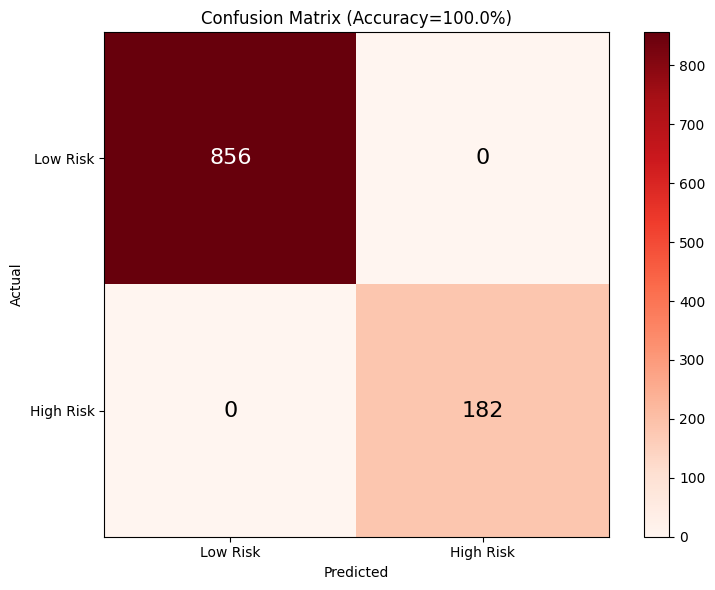

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
im = ax.imshow(cm, cmap='Reds')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Low Risk', 'High Risk'])
ax.set_yticklabels(['Low Risk', 'High Risk'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (Accuracy={accuracy:.1%})')
for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm[i,j]:,}', ha='center', va='center', fontsize=16, color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [9]:
print('Generating predictions...')
all_preds = pipeline.predict(filtered_df)
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
output_df = all_preds.select(
    lit(f'IRP_{timestamp}').alias('PREDICTION_ID'),
    col('ASSET_ID'), col('ASSET_TYPE'),
    col('HIGH_IGNITION_RISK').alias('ACTUAL_RISK'),
    col('PREDICTED_IGNITION_RISK'),
    col('CONDITION_SCORE'), col('AVG_CLEARANCE_DEFICIT'),
    when(col('PREDICTED_IGNITION_RISK') == 1, lit('HIGH')).otherwise(lit('LOW')).alias('RISK_LEVEL'),
    current_date().alias('PREDICTION_DATE'), lit('GRADIENT_BOOSTING_V1').alias('MODEL_VERSION')
)
output_df.write.mode('overwrite').save_as_table('ML.IGNITION_RISK_PREDICTION')
saved = output_df.count()
print(f'Saved {saved:,} predictions to ML.IGNITION_RISK_PREDICTION')

Generating predictions...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/modeling/_internal/snowpark_implementations/snowpark_handlers.py:126: UserWarning: Warning: The Decimal(38, 12) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  dataset = snowpark_dataframe_utils.cast_snowpark_dataframe_column_types(dataset)


Saved 5,000 predictions to ML.IGNITION_RISK_PREDICTION


In [10]:
high_risk_count = (pred_pd['PREDICTED_IGNITION_RISK'] == 1).sum()
print('\n' + '='*60)
print('IGNITION RISK PREDICTOR - SUMMARY')
print('='*60)
print(f'Data: {total_records:,} assets analyzed')
print(f'Model: GradientBoostingClassifier (Accuracy={accuracy:.1%})')
print(f'High Risk: {high_risk_count:,}')
print(f'Output: ML.IGNITION_RISK_PREDICTION ({saved:,} rows)')
print('='*60)


IGNITION RISK PREDICTOR - SUMMARY
Data: 5,000 assets analyzed
Model: GradientBoostingClassifier (Accuracy=100.0%)
High Risk: 182
Output: ML.IGNITION_RISK_PREDICTION (5,000 rows)
